# Explore inferCNV Results

This notebook explores the CNV inference results from infercnvpy.

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import infercnvpy as cnv
    INFERCNVPY_AVAILABLE = True
except ImportError:
    INFERCNVPY_AVAILABLE = False
    print("infercnvpy not available - some plots will be skipped")

sc.settings.verbosity = 2
%matplotlib inline

/Users/gg027/miniforge3/envs/cnv_alignment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load CNV Results

In [3]:
patient_id = 'P0006'
cnv_dir = f'../data/cnv_output/{patient_id}'

# Load the CNV AnnData
adata = sc.read_h5ad(f'{cnv_dir}/{patient_id}_cnv.h5ad')
print(f"Loaded: {adata.shape[0]:,} cells x {adata.shape[1]:,} genes")

# Load CNV profiles per subcluster
cnv_profiles = pd.read_csv(f'{cnv_dir}/cnv_profiles.csv', index_col=0)
print(f"CNV profiles: {cnv_profiles.shape[0]} subclusters x {cnv_profiles.shape[1]} windows")

# Load cell-to-subcluster mapping
cell_subclusters = pd.read_csv(f'{cnv_dir}/cell_subclusters.csv', index_col=0)
print(f"Cell subclusters: {len(cell_subclusters):,} cells")

Loaded: 6,265 cells x 18,965 genes
CNV profiles: 23 subclusters x 1305 windows
Cell subclusters: 6,265 cells


## 2. Overview of CNV Subclusters

In [4]:
# Subcluster sizes
print("CNV Subcluster Sizes:")
print(adata.obs['cnv_leiden'].value_counts().sort_index())

CNV Subcluster Sizes:
cnv_leiden
0     689
1     549
2     530
3     432
4     430
5     427
6     415
7     359
8     328
9     244
10    229
11    214
12    202
13    170
14    160
15    159
16    137
17    134
18    127
19    122
20     75
21     71
22     62
Name: count, dtype: int64


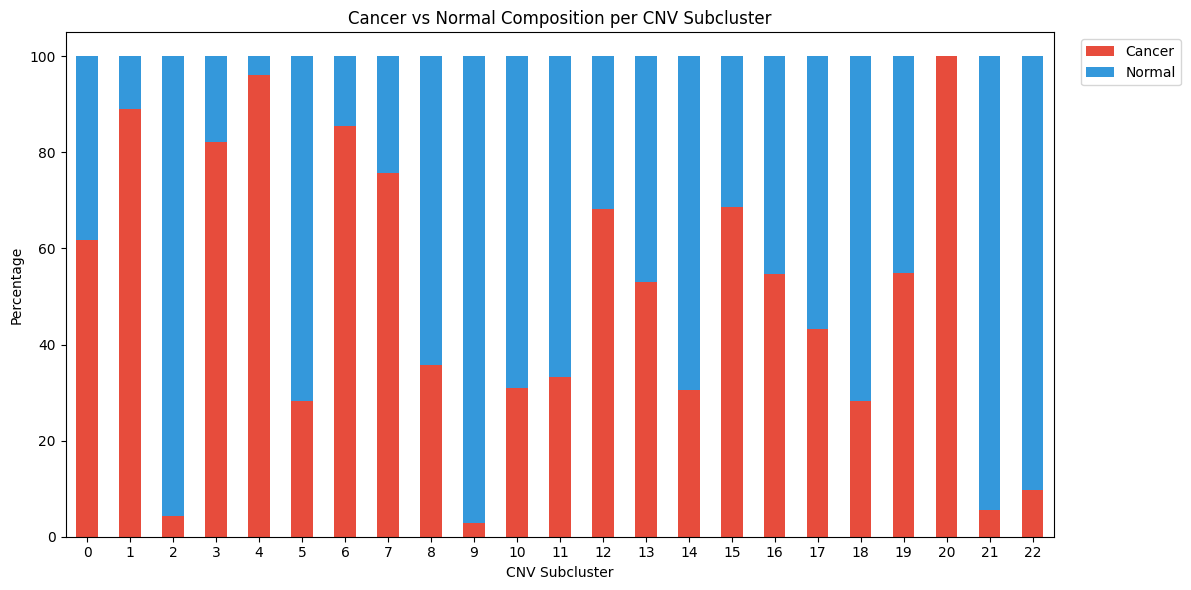

In [5]:
# Cancer vs Normal composition per subcluster
composition = pd.crosstab(
    adata.obs['cnv_leiden'], 
    adata.obs['cancer_vs_normal'],
    normalize='index'
) * 100

fig, ax = plt.subplots(figsize=(12, 6))
composition.plot(kind='bar', stacked=True, ax=ax, color=['#e74c3c', '#3498db'])
ax.set_xlabel('CNV Subcluster')
ax.set_ylabel('Percentage')
ax.set_title('Cancer vs Normal Composition per CNV Subcluster')
ax.legend(title='', bbox_to_anchor=(1.02, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

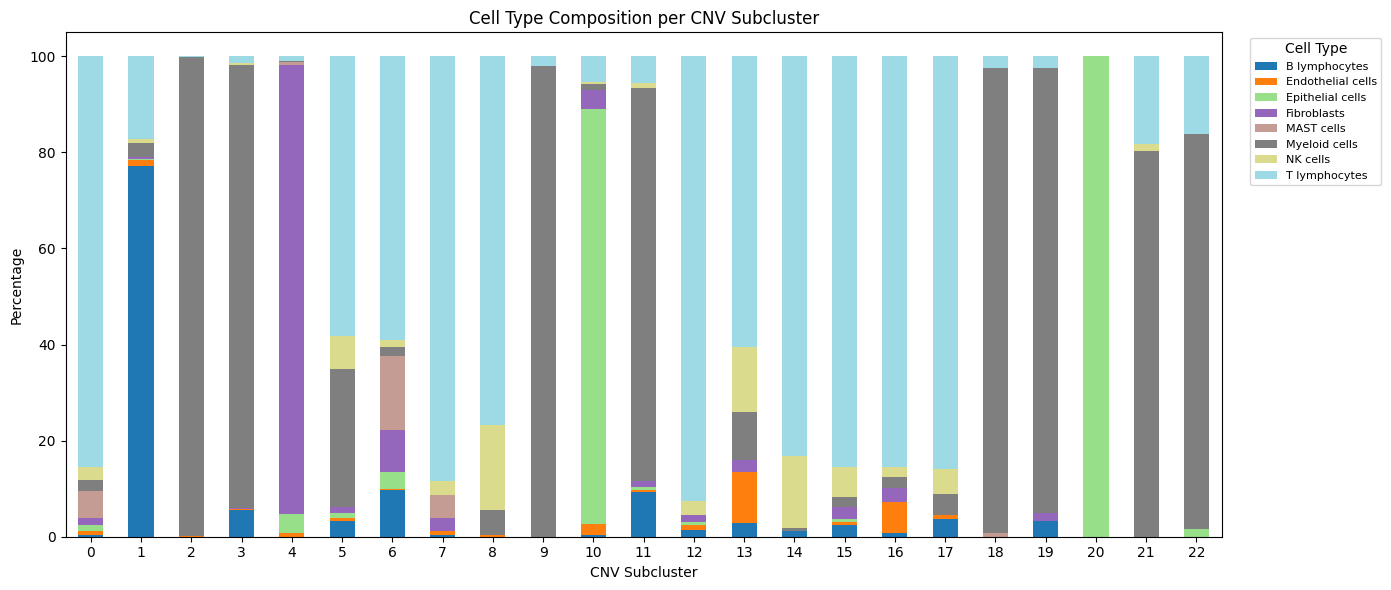

In [6]:
# Cell type composition per subcluster
if 'cell_type' in adata.obs.columns:
    cell_type_comp = pd.crosstab(
        adata.obs['cnv_leiden'],
        adata.obs['cell_type'],
        normalize='index'
    ) * 100
    
    fig, ax = plt.subplots(figsize=(14, 6))
    cell_type_comp.plot(kind='bar', stacked=True, ax=ax, cmap='tab20')
    ax.set_xlabel('CNV Subcluster')
    ax.set_ylabel('Percentage')
    ax.set_title('Cell Type Composition per CNV Subcluster')
    ax.legend(title='Cell Type', bbox_to_anchor=(1.02, 1), fontsize=8)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 3. CNV Score Distribution

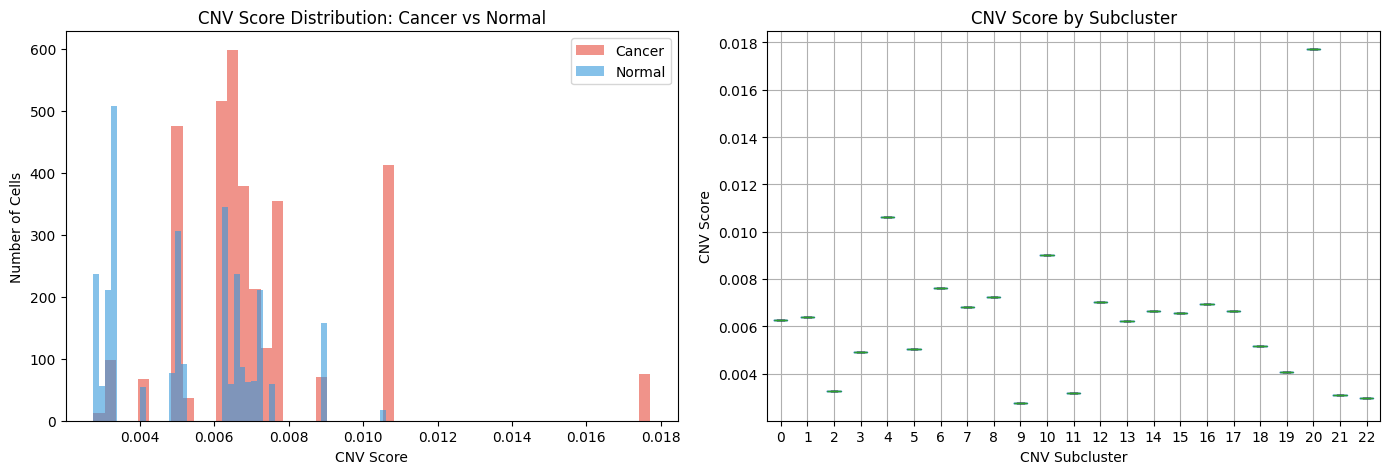

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By cancer vs normal
for label, color in [('Cancer', '#e74c3c'), ('Normal', '#3498db')]:
    mask = adata.obs['cancer_vs_normal'] == label
    axes[0].hist(adata.obs.loc[mask, 'cnv_score'], bins=50, alpha=0.6, label=label, color=color)
axes[0].set_xlabel('CNV Score')
axes[0].set_ylabel('Number of Cells')
axes[0].set_title('CNV Score Distribution: Cancer vs Normal')
axes[0].legend()

# Box plot by subcluster
adata.obs.boxplot(column='cnv_score', by='cnv_leiden', ax=axes[1])
axes[1].set_xlabel('CNV Subcluster')
axes[1].set_ylabel('CNV Score')
axes[1].set_title('CNV Score by Subcluster')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [8]:
# Summary statistics
print("CNV Score Summary by Cancer vs Normal:")
print(adata.obs.groupby('cancer_vs_normal')['cnv_score'].describe())

CNV Score Summary by Cancer vs Normal:
                   count      mean       std       min       25%       50%  \
cancer_vs_normal                                                             
Cancer            3426.0  0.007058  0.002371  0.002755  0.006283  0.006546   
Normal            2839.0  0.005257  0.001893  0.002755  0.003262  0.005055   

                       75%       max  
cancer_vs_normal                      
Cancer            0.007612  0.017719  
Normal            0.006657  0.010603  


/var/folders/3n/d2dmdqcs54z9j_p6mfpghxhm0000gn/T/ipykernel_7361/890638842.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby('cancer_vs_normal')['cnv_score'].describe())


## 4. CNV Heatmap

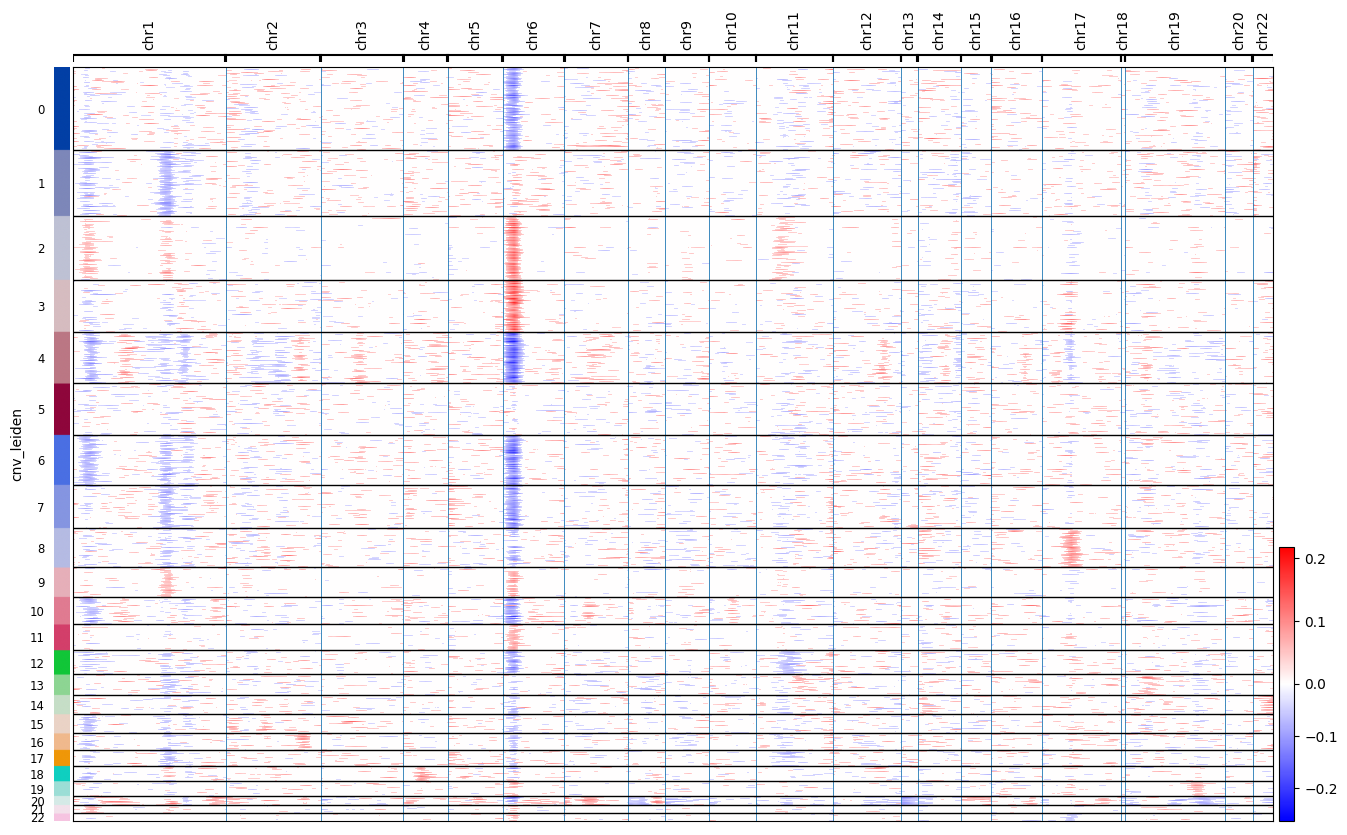

In [9]:
if INFERCNVPY_AVAILABLE:
    # Chromosome heatmap grouped by subcluster
    cnv.pl.chromosome_heatmap(adata, groupby='cnv_leiden')
else:
    print("infercnvpy not available - skipping chromosome heatmap")

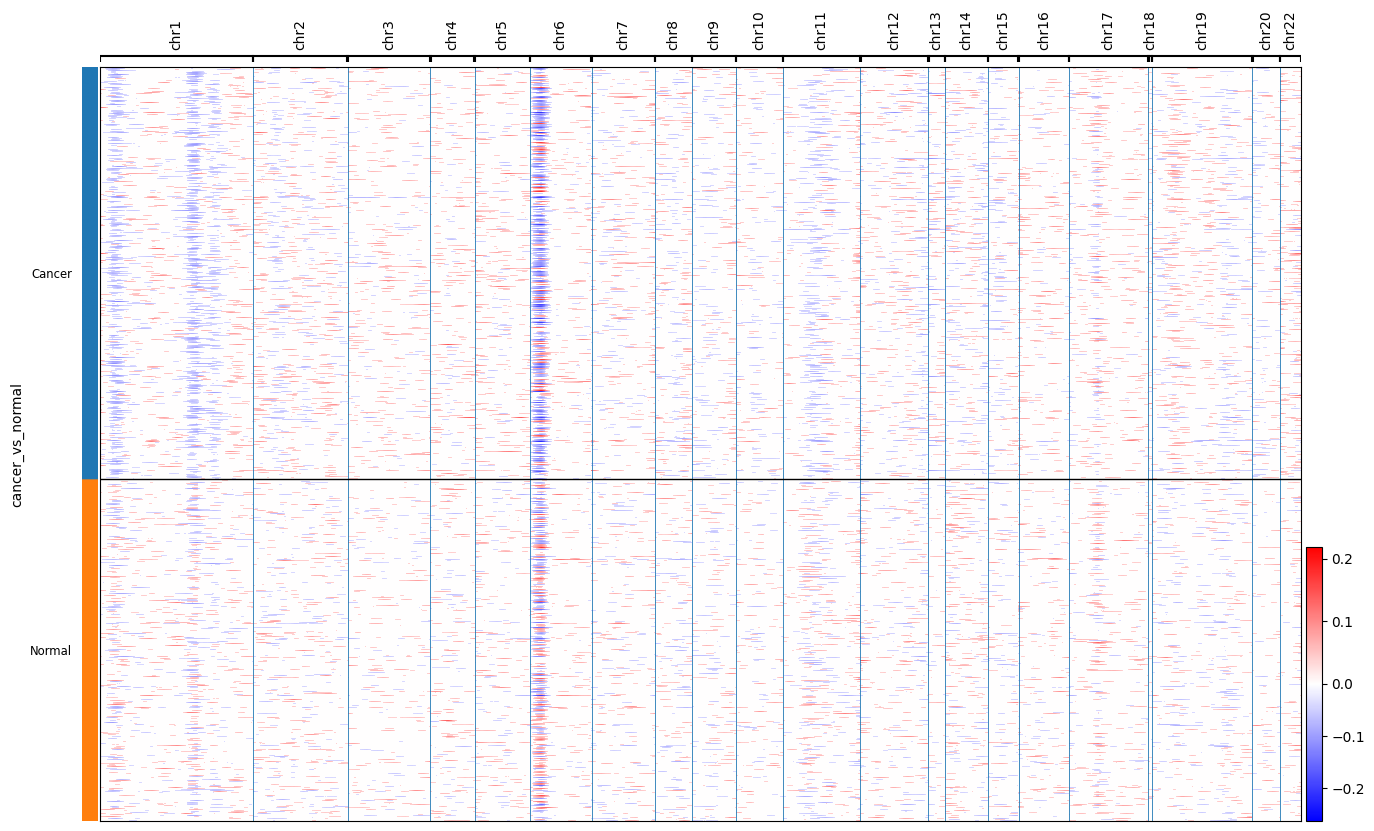

In [10]:
if INFERCNVPY_AVAILABLE:
    # Chromosome heatmap grouped by cancer vs normal
    cnv.pl.chromosome_heatmap(adata, groupby='cancer_vs_normal')

## 5. CNV UMAP and PCA Visualization

In [11]:
# Compute UMAP on CNV space
print("Computing UMAP on CNV profiles...")
cnv.tl.umap(adata)
print("UMAP computed!")

Computing UMAP on CNV profiles...
computing UMAP
    finished (0:00:18)
UMAP computed!


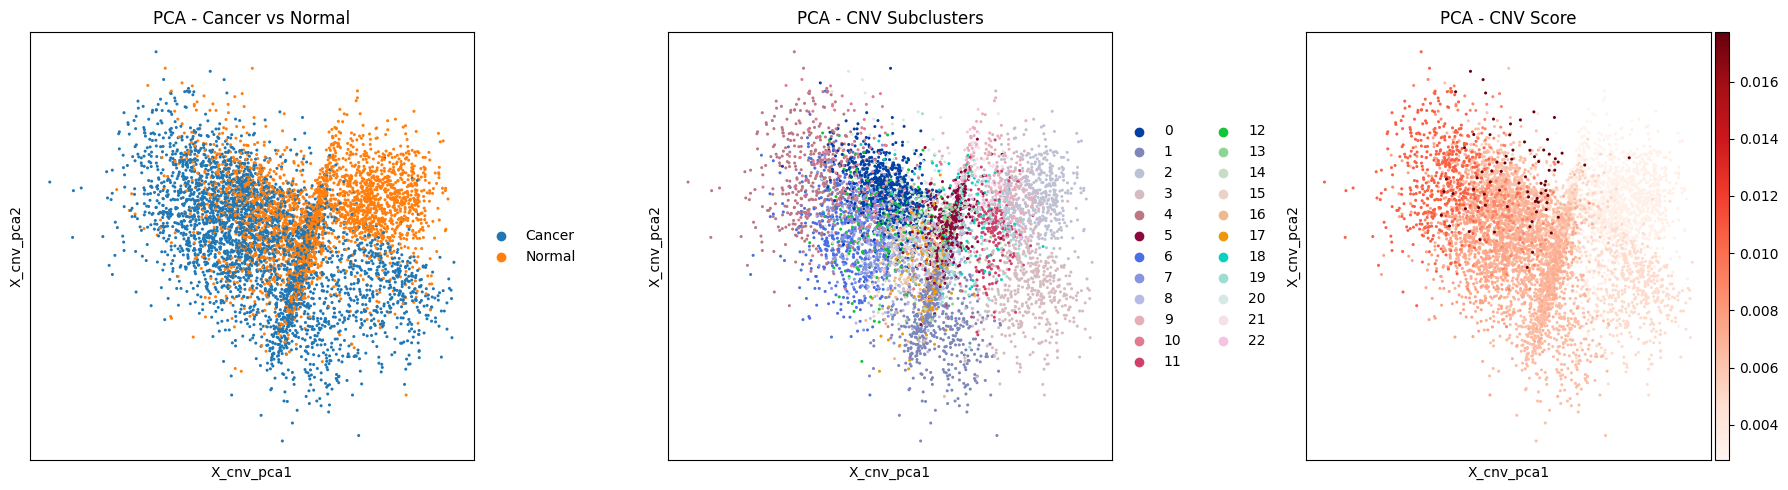

In [12]:
# PCA visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.embedding(adata, basis='X_cnv_pca', color='cancer_vs_normal', ax=axes[0], show=False, title='PCA - Cancer vs Normal')
sc.pl.embedding(adata, basis='X_cnv_pca', color='cnv_leiden', ax=axes[1], show=False, title='PCA - CNV Subclusters')
sc.pl.embedding(adata, basis='X_cnv_pca', color='cnv_score', ax=axes[2], show=False, title='PCA - CNV Score', cmap='Reds')

plt.tight_layout()
plt.show()

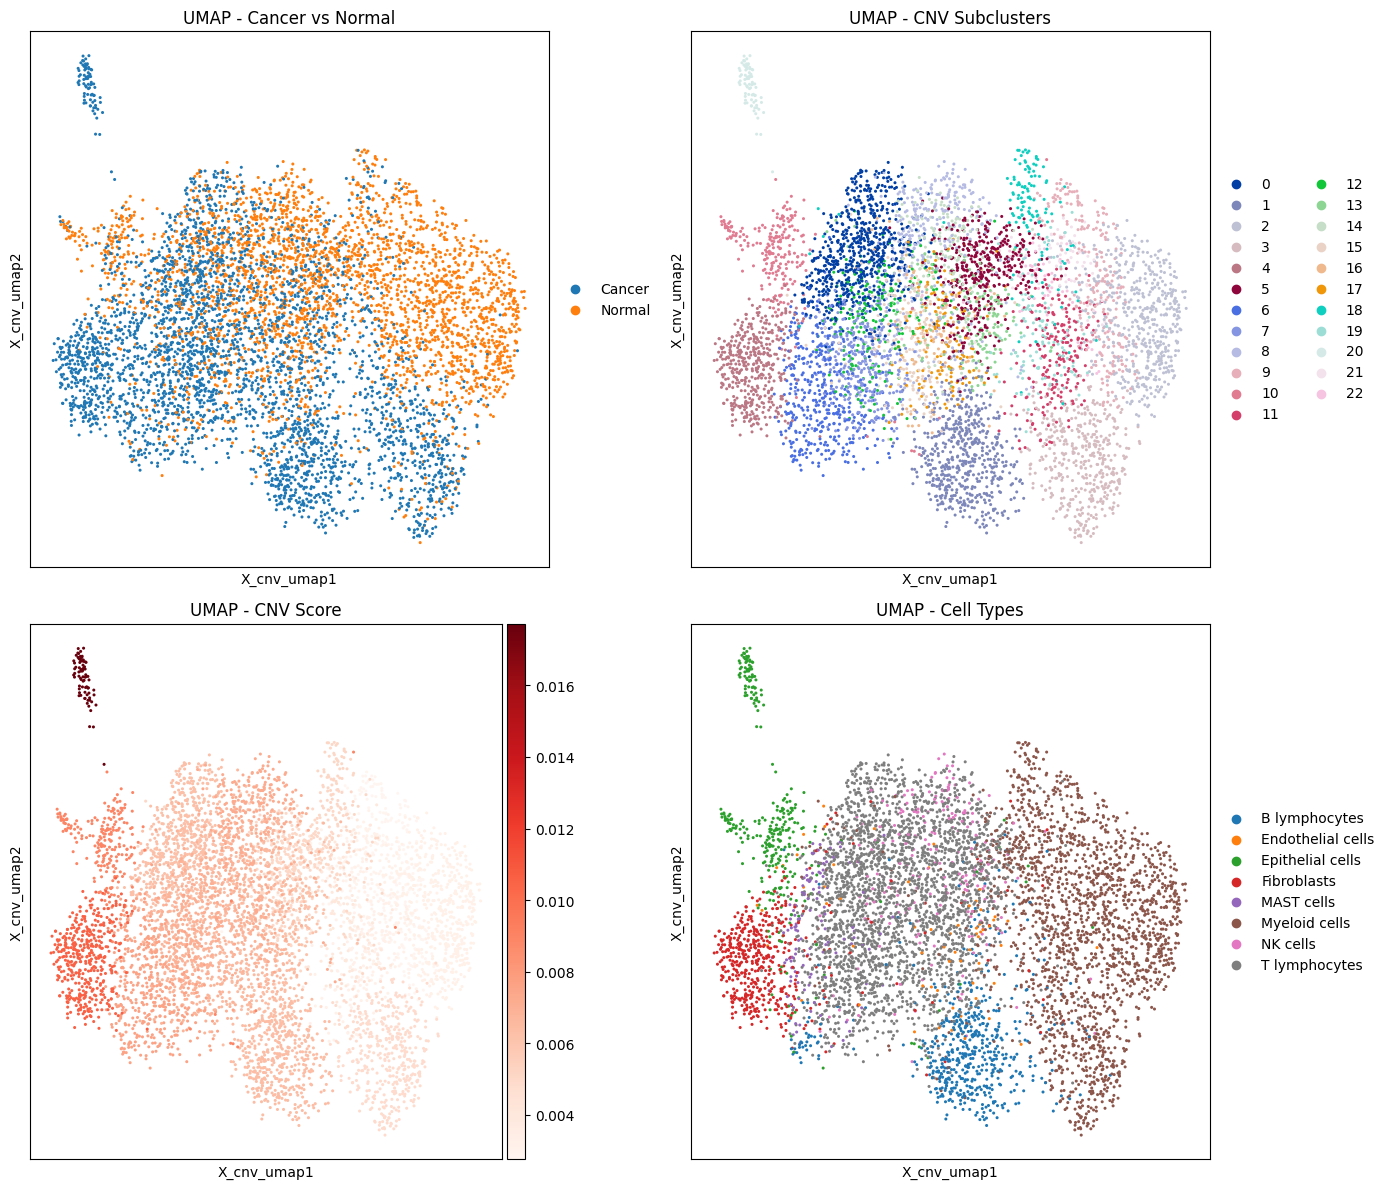

In [13]:
# CNV UMAP visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sc.pl.embedding(adata, basis='X_cnv_umap', color='cancer_vs_normal', ax=axes[0, 0], show=False, title='UMAP - Cancer vs Normal')
sc.pl.embedding(adata, basis='X_cnv_umap', color='cnv_leiden', ax=axes[0, 1], show=False, title='UMAP - CNV Subclusters')
sc.pl.embedding(adata, basis='X_cnv_umap', color='cnv_score', ax=axes[1, 0], show=False, title='UMAP - CNV Score', cmap='Reds')

if 'cell_type' in adata.obs.columns:
    sc.pl.embedding(adata, basis='X_cnv_umap', color='cell_type', ax=axes[1, 1], show=False, title='UMAP - Cell Types')
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# 3D UMAP visualization
import umap
import plotly.express as px
import plotly.graph_objects as go

# Compute 3D UMAP from CNV PCA
print("Computing 3D UMAP...")
reducer_3d = umap.UMAP(n_components=3, random_state=42)
umap_3d = reducer_3d.fit_transform(adata.obsm['X_cnv_pca'])
adata.obsm['X_cnv_umap_3d'] = umap_3d
print("3D UMAP computed!")

Computing 3D UMAP...


/Users/gg027/miniforge3/envs/cnv_alignment/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


3D UMAP computed!


In [15]:
# Create dataframe for 3D plotting
plot_df = pd.DataFrame({
    'UMAP1': adata.obsm['X_cnv_umap_3d'][:, 0],
    'UMAP2': adata.obsm['X_cnv_umap_3d'][:, 1],
    'UMAP3': adata.obsm['X_cnv_umap_3d'][:, 2],
    'cancer_vs_normal': adata.obs['cancer_vs_normal'].values,
    'cnv_leiden': adata.obs['cnv_leiden'].astype(str).values,
    'cnv_score': adata.obs['cnv_score'].values,
})

if 'cell_type' in adata.obs.columns:
    plot_df['cell_type'] = adata.obs['cell_type'].values

# 3D scatter - Cancer vs Normal
fig = px.scatter_3d(
    plot_df, 
    x='UMAP1', y='UMAP2', z='UMAP3',
    color='cancer_vs_normal',
    color_discrete_map={'Cancer': '#e74c3c', 'Normal': '#3498db'},
    title='3D UMAP - Cancer vs Normal',
    opacity=0.7,
    height=700
)
fig.update_traces(marker=dict(size=3))
fig.show()

In [16]:
# 3D scatter - CNV Subclusters
fig = px.scatter_3d(
    plot_df, 
    x='UMAP1', y='UMAP2', z='UMAP3',
    color='cnv_leiden',
    title='3D UMAP - CNV Subclusters',
    opacity=0.7,
    height=700
)
fig.update_traces(marker=dict(size=3))
fig.show()

In [17]:
# 3D scatter - CNV Score (continuous)
fig = px.scatter_3d(
    plot_df, 
    x='UMAP1', y='UMAP2', z='UMAP3',
    color='cnv_score',
    color_continuous_scale='Reds',
    title='3D UMAP - CNV Score',
    opacity=0.7,
    height=700
)
fig.update_traces(marker=dict(size=3))
fig.show()

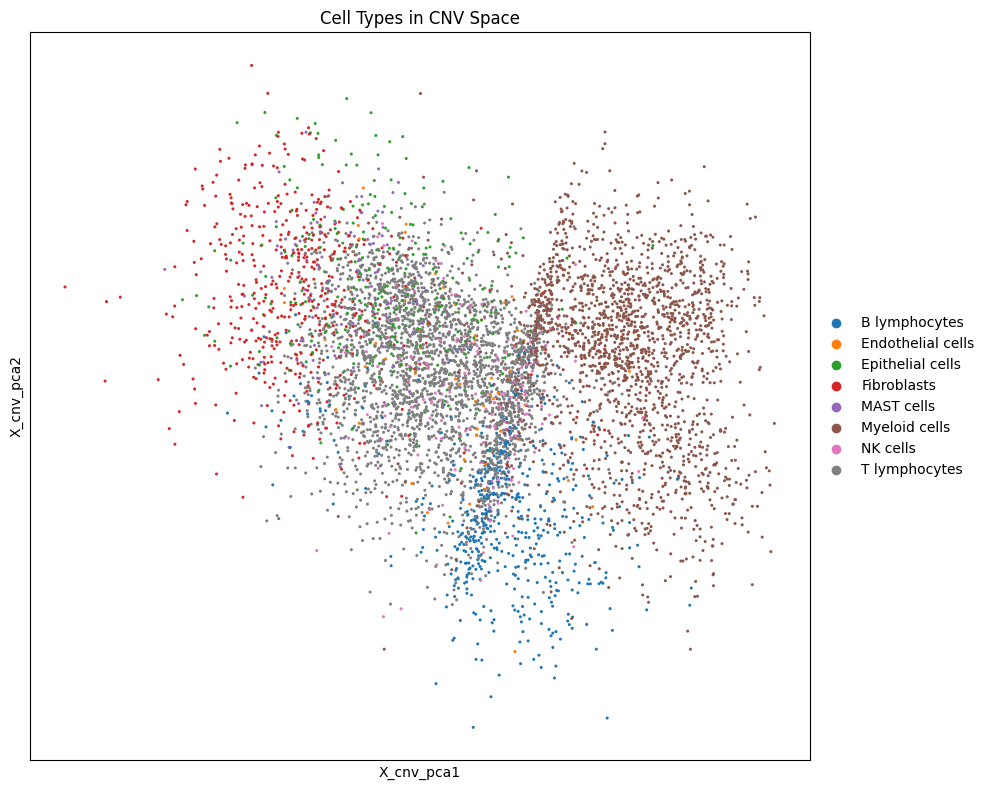

In [18]:
# Color by cell type if available
if 'cell_type' in adata.obs.columns:
    fig, ax = plt.subplots(figsize=(10, 8))
    sc.pl.embedding(adata, basis='X_cnv_pca', color='cell_type', ax=ax, show=False, title='Cell Types in CNV Space')
    plt.tight_layout()
    plt.show()

## 6. CNV Profile Analysis

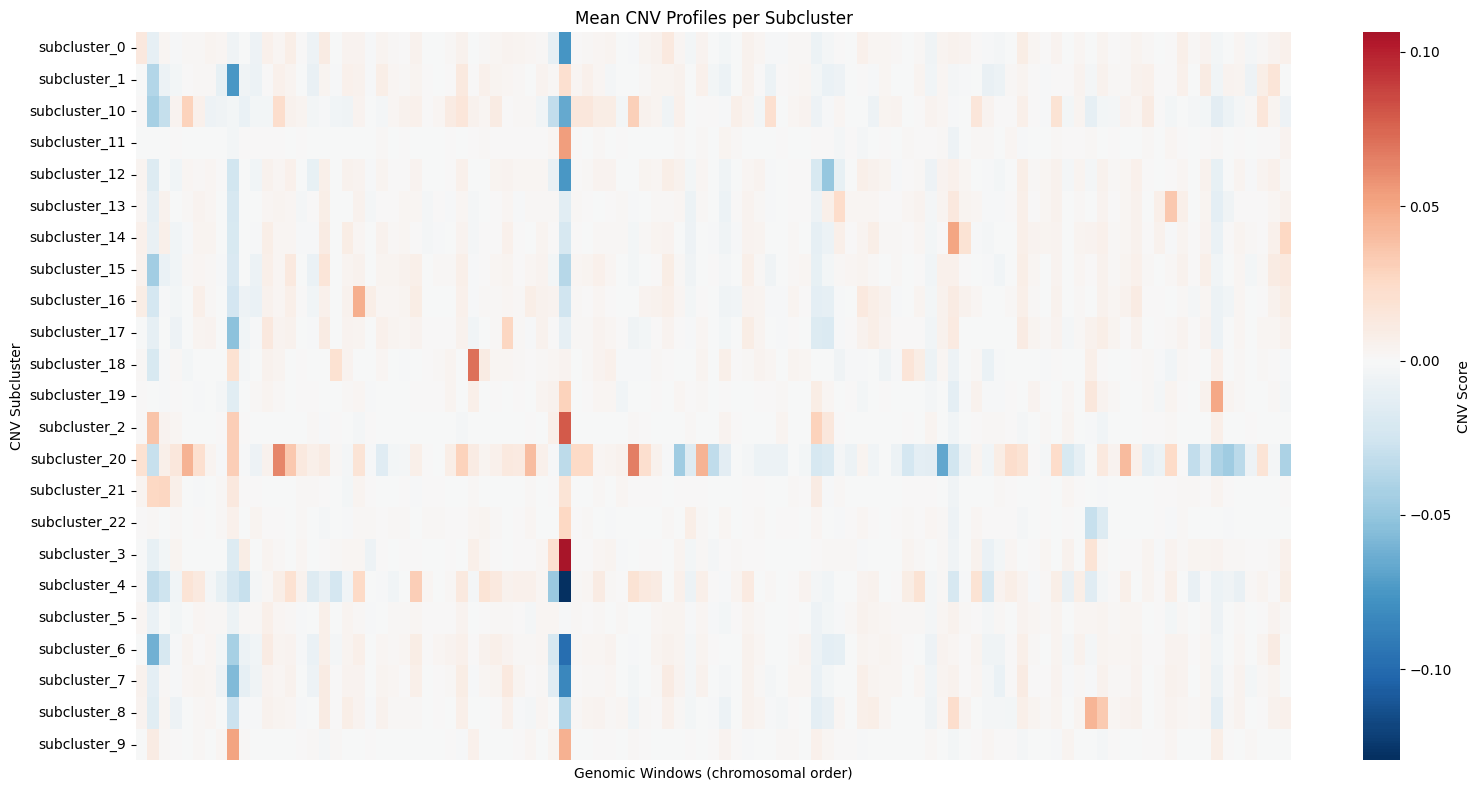

In [19]:
# Heatmap of mean CNV profiles per subcluster
fig, ax = plt.subplots(figsize=(16, 8))

# Subsample columns for visualization
n_windows = cnv_profiles.shape[1]
step = max(1, n_windows // 100)  # Show ~100 windows
cnv_subset = cnv_profiles.iloc[:, ::step]

sns.heatmap(
    cnv_subset, 
    cmap='RdBu_r', 
    center=0,
    ax=ax,
    xticklabels=False,
    yticklabels=True,
    cbar_kws={'label': 'CNV Score'}
)
ax.set_xlabel('Genomic Windows (chromosomal order)')
ax.set_ylabel('CNV Subcluster')
ax.set_title('Mean CNV Profiles per Subcluster')
plt.tight_layout()
plt.show()

In [20]:
# Profile statistics
print("CNV Profile Statistics per Subcluster:")
profile_stats = pd.DataFrame({
    'mean': cnv_profiles.mean(axis=1),
    'std': cnv_profiles.std(axis=1),
    'min': cnv_profiles.min(axis=1),
    'max': cnv_profiles.max(axis=1),
    'range': cnv_profiles.max(axis=1) - cnv_profiles.min(axis=1)
})
print(profile_stats)

CNV Profile Statistics per Subcluster:
                   mean       std       min       max     range
subcluster_0   0.000602  0.008883 -0.096279  0.021173  0.117452
subcluster_1  -0.000196  0.008985 -0.074676  0.029949  0.104625
subcluster_10  0.000199  0.012420 -0.089003  0.031406  0.120409
subcluster_11  0.000850  0.004934 -0.007367  0.063475  0.070842
subcluster_12 -0.000687  0.010341 -0.092882  0.022965  0.115846
subcluster_13  0.001252  0.005966 -0.024163  0.034948  0.059111
subcluster_14  0.001517  0.007054 -0.031884  0.050939  0.082824
subcluster_15  0.000529  0.007723 -0.056015  0.020416  0.076431
subcluster_16  0.001311  0.007647 -0.033122  0.054914  0.088036
subcluster_17  0.000874  0.007529 -0.052766  0.040500  0.093266
subcluster_18  0.001634  0.007610 -0.024089  0.073483  0.097572
subcluster_19  0.001281  0.005943 -0.016097  0.050502  0.066599
subcluster_2   0.001997  0.009347 -0.009309  0.097352  0.106662
subcluster_20  0.000334  0.022740 -0.091373  0.076268  0.167641
s

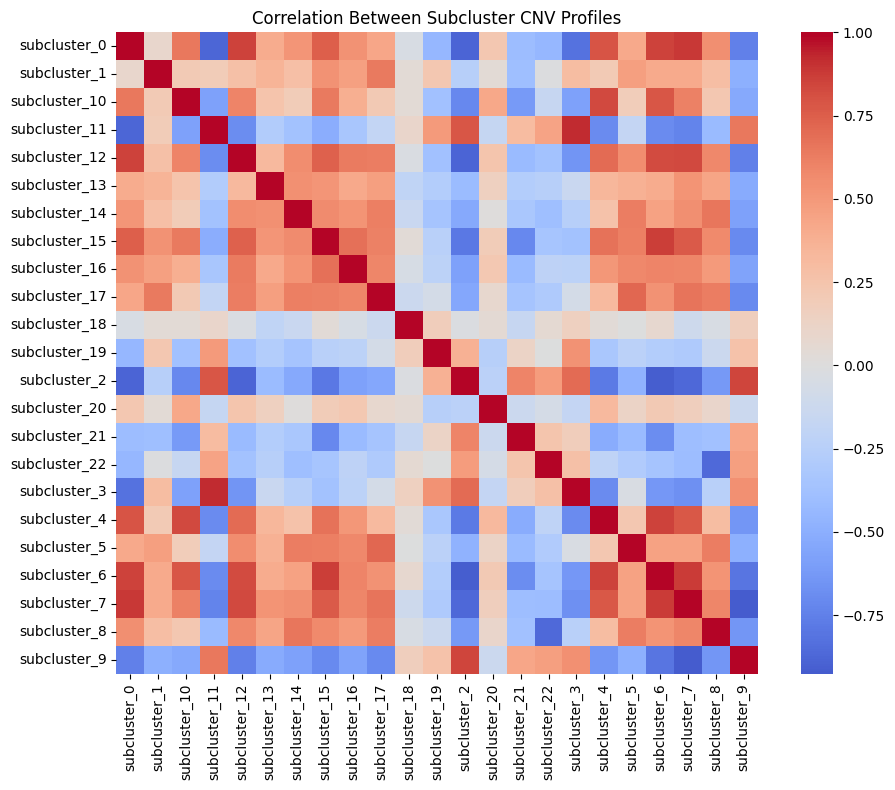

In [21]:
# Correlation between subcluster profiles
profile_corr = cnv_profiles.T.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    profile_corr, 
    cmap='coolwarm', 
    center=0,
    annot=True if len(profile_corr) <= 15 else False,
    fmt='.2f',
    ax=ax,
    square=True
)
ax.set_title('Correlation Between Subcluster CNV Profiles')
plt.tight_layout()
plt.show()

## 7. Identify High-CNV Subclusters

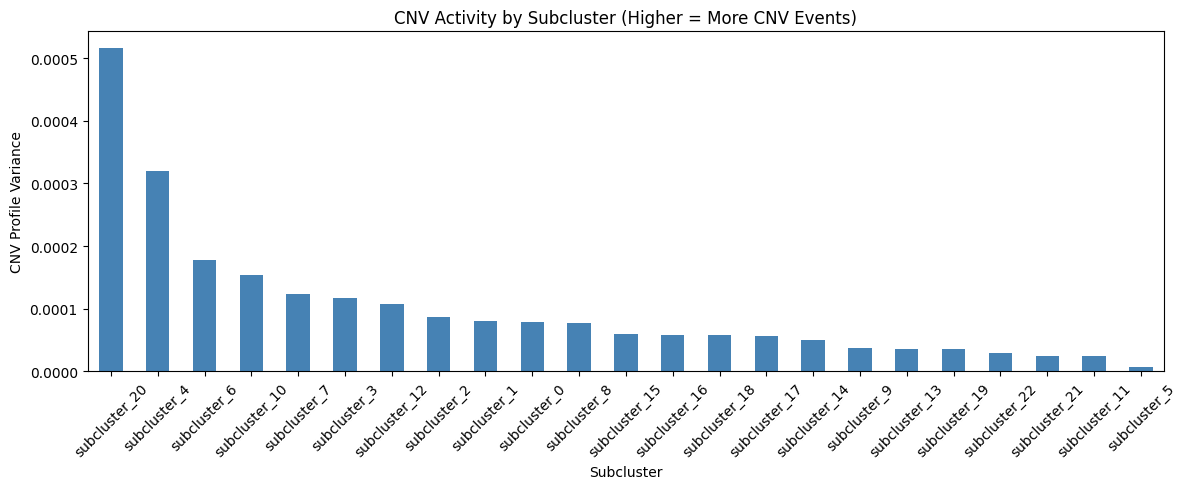


Top 5 subclusters with highest CNV activity:
subcluster_20    0.000517
subcluster_4     0.000320
subcluster_6     0.000178
subcluster_10    0.000154
subcluster_7     0.000124
dtype: float64


In [22]:
# Subclusters with highest CNV activity (variance)
subcluster_variance = cnv_profiles.var(axis=1).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
subcluster_variance.plot(kind='bar', ax=ax, color='steelblue')
ax.set_xlabel('Subcluster')
ax.set_ylabel('CNV Profile Variance')
ax.set_title('CNV Activity by Subcluster (Higher = More CNV Events)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTop 5 subclusters with highest CNV activity:")
print(subcluster_variance.head())

In [23]:
# What is the cancer/normal composition of high-CNV subclusters?
high_cnv_clusters = subcluster_variance.head(5).index.str.replace('subcluster_', '').tolist()

print("Cancer vs Normal composition of top 5 high-CNV subclusters:")
for cluster in high_cnv_clusters:
    mask = adata.obs['cnv_leiden'] == cluster
    counts = adata.obs.loc[mask, 'cancer_vs_normal'].value_counts()
    total = counts.sum()
    print(f"  Subcluster {cluster}: {counts.get('Cancer', 0)} cancer ({100*counts.get('Cancer', 0)/total:.1f}%), "
          f"{counts.get('Normal', 0)} normal ({100*counts.get('Normal', 0)/total:.1f}%)")

Cancer vs Normal composition of top 5 high-CNV subclusters:
  Subcluster 20: 75 cancer (100.0%), 0 normal (0.0%)
  Subcluster 4: 413 cancer (96.0%), 17 normal (4.0%)
  Subcluster 6: 355 cancer (85.5%), 60 normal (14.5%)
  Subcluster 10: 71 cancer (31.0%), 158 normal (69.0%)
  Subcluster 7: 272 cancer (75.8%), 87 normal (24.2%)


## 8. Summary for Contrastive Learning

In [24]:
print("=" * 60)
print("SUMMARY FOR CONTRASTIVE LEARNING")
print("=" * 60)
print(f"\nPatient: {patient_id}")
print(f"Total cells: {adata.n_obs:,}")
print(f"  - Cancer: {(adata.obs['cancer_vs_normal'] == 'Cancer').sum():,}")
print(f"  - Normal: {(adata.obs['cancer_vs_normal'] == 'Normal').sum():,}")
print(f"\nCNV subclusters: {adata.obs['cnv_leiden'].nunique()}")
print(f"CNV windows: {cnv_profiles.shape[1]}")
print(f"\nEach cell has:")
print(f"  - Expression profile: {adata.n_vars} genes")
print(f"  - CNV profile: {adata.obsm['X_cnv'].shape[1]} windows")
print(f"  - Subcluster assignment: cnv_leiden")
print(f"\nFor contrastive learning:")
print(f"  - Anchor: Mean CNV profile per subcluster ({cnv_profiles.shape})")
print(f"  - Positive: Cells in same subcluster")
print(f"  - Negative: Cells in different subclusters")

SUMMARY FOR CONTRASTIVE LEARNING

Patient: P0006
Total cells: 6,265
  - Cancer: 3,426
  - Normal: 2,839

CNV subclusters: 23
CNV windows: 1305

Each cell has:
  - Expression profile: 18965 genes
  - CNV profile: 1305 windows
  - Subcluster assignment: cnv_leiden

For contrastive learning:
  - Anchor: Mean CNV profile per subcluster ((23, 1305))
  - Positive: Cells in same subcluster
  - Negative: Cells in different subclusters
